In [1829]:
%load_ext autoreload
%autoreload 2
from parse.parse_reactions import ReactionParser
from parse.parse_species import parse_species_string, parse_all_species
from parse.parse_rate_constant import RateConstantParser
from parse.parse_input import separate_input_file, parse_args_kwargs
from create_diff_eqs import kinetic_odes
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from functools import partial

np.set_printoptions(precision = 5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1830]:
sections = separate_input_file('input/sample_input.txt')
species_section = sections['species']
species, equivalent_species = parse_all_species(species_section)
print(species)
print(equivalent_species)

{'general': [], 'species': [], 'rate constants': [], 'reactions': []}
[Species(name='I', type=<SpeciesType.UNIT: 1>, FW=50.0, c0=0.005), Species(name='R', type=<SpeciesType.UNIT: 1>, FW=25.0, c0=0.0), Species(name='A', type=<SpeciesType.UNIT: 1>, FW=100.0, c0=1.5), Species(name='B', type=<SpeciesType.UNIT: 1>, FW=200.0, c0=1.5), Species(name='P[R.A]', type=<SpeciesType.POLY: 2>, FW=1.0, c0=0.0), Species(name='P[R.B]', type=<SpeciesType.POLY: 2>, FW=1.0, c0=0.0), Species(name='P[A.A]', type=<SpeciesType.POLY: 2>, FW=1.0, c0=0.0), Species(name='P[A.B]', type=<SpeciesType.POLY: 2>, FW=1.0, c0=0.0), Species(name='P[B.A]', type=<SpeciesType.POLY: 2>, FW=1.0, c0=0.0), Species(name='P[B.B]', type=<SpeciesType.POLY: 2>, FW=1.0, c0=0.0), Species(name='D', type=<SpeciesType.POLY: 2>, FW=1.0, c0=0.0)]
[EquivalentSpecies(name='P[-.A]', type=<SpeciesType.POLY: 2>, eq=['P[A.A]', 'P[B.A]']), EquivalentSpecies(name='P[-.B]', type=<SpeciesType.POLY: 2>, eq=['P[A.B]', 'P[B.B]'])]


In [1831]:
species_string = 'U I      c0=0.005 FW=50.0'
parse_species_string(species_string)

Species(name='I', type=<SpeciesType.UNIT: 1>, FW=50.0, c0=0.005)

In [1832]:
constants_section = sections['rate constants']
rcp = RateConstantParser()
rcp.parse_all_constants(constants_section)

In [1833]:
reaction_string = 'PR 23P[A.A] + B -kpAAB-> 5P[A.B]'
rp = ReactionParser(species, equivalent_species, rcp)
rp.parse_reaction_string(reaction_string)

('PR',
 [ReactionSpecies(species=Species(name='P[A.A]', type=<SpeciesType.POLY: 2>, FW=1.0, c0=0.0), coeff=23),
  ReactionSpecies(species=Species(name='B', type=<SpeciesType.UNIT: 1>, FW=200.0, c0=1.5), coeff=1)],
 [ReactionSpecies(species=Species(name='P[A.B]', type=<SpeciesType.POLY: 2>, FW=1.0, c0=0.0), coeff=5)],
 ['kpAAB'], {})

In [1834]:
reactions_section = sections['reactions']
all_reactions = rp.parse_all_reactions(reactions_section)
print(all_reactions)

[Rate Constant:['kd'], {'f': 0.5},
Unit Reactant Species: [ReactionSpecies(species=Species(name='I', type=<SpeciesType.UNIT: 1>, FW=50.0, c0=0.005), coeff=1)],
Poly Reactant Species: [],
Unit Product Species: [ReactionSpecies(species=Species(name='R', type=<SpeciesType.UNIT: 1>, FW=25.0, c0=0.0), coeff=2)],
Poly Product Species: []

, Rate Constant:['kpAAA'], {},
Unit Reactant Species: [ReactionSpecies(species=Species(name='R', type=<SpeciesType.UNIT: 1>, FW=25.0, c0=0.0), coeff=1), ReactionSpecies(species=Species(name='A', type=<SpeciesType.UNIT: 1>, FW=100.0, c0=1.5), coeff=1)],
Poly Reactant Species: [],
Unit Product Species: [],
Poly Product Species: [ReactionSpecies(species=Species(name='P[R.A]', type=<SpeciesType.POLY: 2>, FW=1.0, c0=0.0), coeff=1)]

, Rate Constant:['kpBBB'], {},
Unit Reactant Species: [ReactionSpecies(species=Species(name='R', type=<SpeciesType.UNIT: 1>, FW=25.0, c0=0.0), coeff=1), ReactionSpecies(species=Species(name='B', type=<SpeciesType.UNIT: 1>, FW=200.0, 

In [1835]:
str = "ktdBB A=1e5 E=1e-3"
r = rcp.parse_constants_string(str)
r


['ktdBB'], {}

In [1836]:
c = rcp.parse_reaction_constant("PR P[R.A] + A -kpAAA-> P[A.A]")
print(c)

['kpAAA'], {}


In [1837]:
from itertools import product

# Given string format
template_string = 'P[-.A] + P[-.B] -kpABC-> D'

# Define possible replacements for "P[-.A]" and "P[-.B]"
replacements_A = ['P[A.A]', 'P[B.A]']
replacements_B = ['P[A.B]', 'P[B.B]']

# Generate all permutations
permutations = list(product(replacements_A, replacements_B))

# Create a list of strings with permutations
for p in permutations:
    print(p)
result_strings = [template_string.replace('P[-.A]', p[0]).replace('P[-.B]', p[1]) for p in permutations]

# Print the result
for idx, result_string in enumerate(result_strings, start=1):
    print(f'{idx}: {result_string}')


('P[A.A]', 'P[A.B]')
('P[A.A]', 'P[B.B]')
('P[B.A]', 'P[A.B]')
('P[B.A]', 'P[B.B]')
1: P[A.A] + P[A.B] -kpABC-> D
2: P[A.A] + P[B.B] -kpABC-> D
3: P[B.A] + P[A.B] -kpABC-> D
4: P[B.A] + P[B.B] -kpABC-> D


In [1838]:
rp.modify_reactions_section(reactions_section)

['ID I -kd-> 2R',
 'IN R + A -kpAAA-> P[R.A]',
 'IN R + B -kpBBB-> P[R.B]',
 'PR P[R.A] + A -kpAAA-> P[A.A]',
 'PR P[R.A] + B -kpAAB-> P[A.B]',
 'PR P[R.B] + A -kpBBA-> P[B.A]',
 'PR P[R.B] + B -kpBBB-> P[B.B]',
 'PR P[A.A] + A -kpAAA-> P[A.A]',
 'PR P[A.A] + B -kpAAB-> P[A.B]',
 'PR P[A.B] + A -kpABA-> P[B.A]',
 'PR P[A.B] + B -kpABB-> P[B.B]',
 'PR P[B.A] + A -kpBAA-> P[A.A]',
 'PR P[B.A] + B -kpBAB-> P[A.B]',
 'PR P[B.B] + A -kpBBA-> P[B.A]',
 'PR P[B.B] + B -kpBBB-> P[B.B]',
 'DP P[B.B] -kdpBB-> P[A.B] + B',
 'DP P[B.B] -kdpBB-> P[B.B] + B',
 'TC P[A.A] + P[A.A] -ktcAA-> D',
 'TC P[A.A] + P[B.A] -ktcAA-> D',
 'TC P[B.A] + P[A.A] -ktcAA-> D',
 'TC P[B.A] + P[B.A] -ktcAA-> D',
 'TC P[A.A] + P[A.B] -ktcAB-> D',
 'TC P[A.A] + P[B.B] -ktcAB-> D',
 'TC P[B.A] + P[A.B] -ktcAB-> D',
 'TC P[B.A] + P[B.B] -ktcAB-> D',
 'TC P[A.B] + P[A.B] -ktcBB-> D',
 'TC P[A.B] + P[B.B] -ktcBB-> D',
 'TC P[B.B] + P[A.B] -ktcBB-> D',
 'TC P[B.B] + P[B.B] -ktcBB-> D',
 'TD P[A.A] + P[A.A] -ktcAA-> 2D',
 'TD 

In [1839]:
t = [0, 300]
c_dict = {'I': 0.005, 'R': 0, 'A': 1.5, 'B': 1.5, 'P[R.A]': 0, 'P[R.B]': 0, 
            'P[A.A]': 0, 'P[A.B]': 0, 'P[B.A]': 0, 'P[B.B]': 0, 'D': 0}

dcdt = kinetic_odes(t, c_dict, all_reactions)
dcdt

key for reactant I
rate 1: 100000.0
other part: 0.005
rate 2: 500.0
dcdt[i] for reactant: -500.0
end of species
key for product R
rate 1: 100000.0
other part: 0.005
rate 2: 500.0
dcdt[i] for product: 500.0
key for reactant R
rate 1: 30.6
other part: 0
other part: 1.5
rate 2: 0.0
dcdt[i] for reactant: 500.0
key for reactant R
rate 1: 0.643
other part: 0
other part: 1.5
rate 2: 0.0
dcdt[i] for reactant: 500.0
end of species
key for reactant A
rate 1: 30.6
other part: 0
other part: 1.5
rate 2: 0.0
dcdt[i] for reactant: 0.0
key for reactant A
rate 1: 30.6
other part: 1.5
other part: 0
rate 2: 0.0
dcdt[i] for reactant: 0.0
key for reactant A
rate 1: 0.311
other part: 1.5
other part: 0
rate 2: 0.0
dcdt[i] for reactant: 0.0
key for reactant A
rate 1: 30.6
other part: 1.5
other part: 0
rate 2: 0.0
dcdt[i] for reactant: 0.0
key for reactant A
rate 1: 0.735
other part: 1.5
other part: 0
rate 2: 0.0
dcdt[i] for reactant: 0.0
key for reactant A
rate 1: 12.2
other part: 1.5
other part: 0
rate 2: 0.

array([-500.,  500.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.])

In [1840]:
t = [0, 300]

def fun_for_solve_ivp(t, c):
    return fun(t, c_dict, reactions_list=all_reactions)

# Call solve_ivp with kinetic_odes and necessary parameters
sol = solve_ivp(fun_for_solve_ivp, t, list(c_dict.values()), method='BDF')
#print(sol.y)

key for reactant I
rate 1: 100000.0
other part: 0.005
rate 2: 500.0
dcdt[i] for reactant: -500.0
end of species
key for product R
rate 1: 100000.0
other part: 0.005
rate 2: 500.0
dcdt[i] for product: 500.0
key for reactant R
rate 1: 30.6
other part: 0
other part: 1.5
rate 2: 0.0
dcdt[i] for reactant: 500.0
key for reactant R
rate 1: 0.643
other part: 0
other part: 1.5
rate 2: 0.0
dcdt[i] for reactant: 500.0
end of species
key for reactant A
rate 1: 30.6
other part: 0
other part: 1.5
rate 2: 0.0
dcdt[i] for reactant: 0.0
key for reactant A
rate 1: 30.6
other part: 1.5
other part: 0
rate 2: 0.0
dcdt[i] for reactant: 0.0
key for reactant A
rate 1: 0.311
other part: 1.5
other part: 0
rate 2: 0.0
dcdt[i] for reactant: 0.0
key for reactant A
rate 1: 30.6
other part: 1.5
other part: 0
rate 2: 0.0
dcdt[i] for reactant: 0.0
key for reactant A
rate 1: 0.735
other part: 1.5
other part: 0
rate 2: 0.0
dcdt[i] for reactant: 0.0
key for reactant A
rate 1: 12.2
other part: 1.5
other part: 0
rate 2: 0.

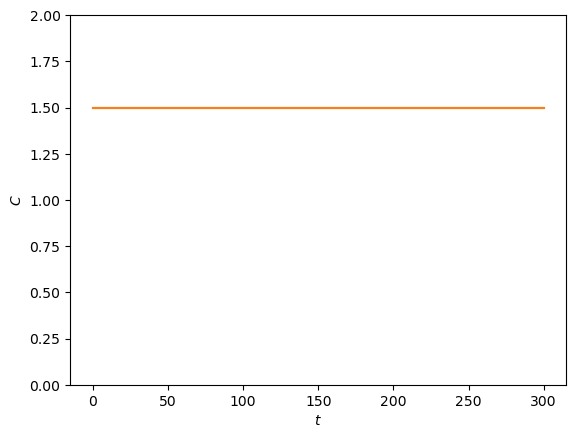

In [1841]:
plt.plot(sol.t, sol.y[2, :])
plt.plot(sol.t, sol.y[3, :])
plt.xlabel('$t$') 
plt.ylabel('$C$')
plt.ylim(0, 2)
plt.show()